#Carlos Enrique Jaramillo Aros

#MCD - FAII

#1144180744

Doble Click - Definicion Taller
<!--
12. Ejercicio en Clase
Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, 
encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase.
Compare los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones
y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.
-->

In [1]:
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Librerias para definicion
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import seaborn as sns

In [2]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()


'''
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/06-05-Heart.csv?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
df = pd.read_csv(url, sep=',')
print(df.shape)
df.head()
'''

'\nurl = \'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/06-05-Heart.csv?raw=true\'\n#data = pd.read_excel("content/datosEmpleo.xlsx",index_col=\'mes\',parse_dates=True)\ndf = pd.read_csv(url, sep=\',\')\nprint(df.shape)\ndf.head()\n'

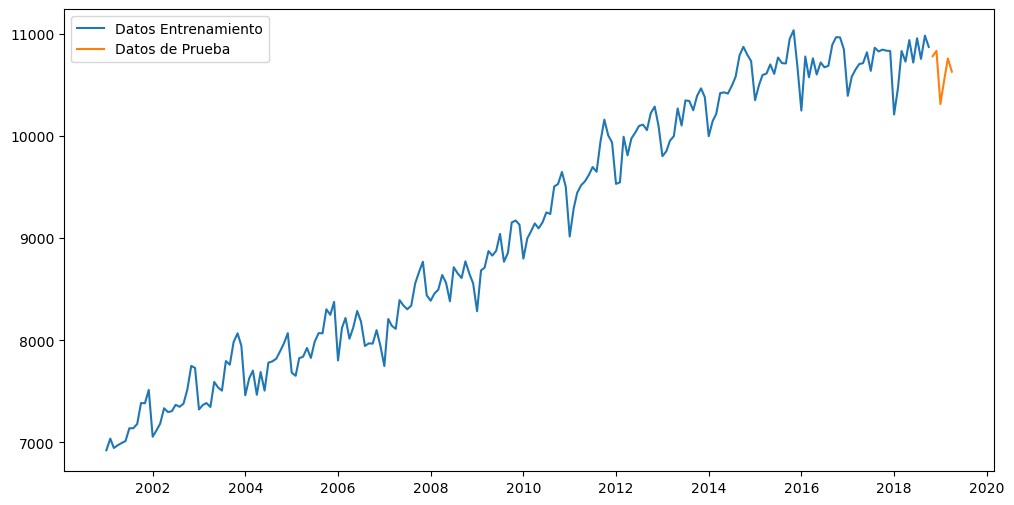

In [3]:
# Split de data original (ocupados)
train_len = 214
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td[["Ocupados"]],label="Datos Entrenamiento")
plt.plot(test_td[["Ocupados"]],label="Datos de Prueba")
plt.legend()
plt.show()

In [4]:
## Generacion de dummies para los meses y split de estos 
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)

train_dummy = month_dummies[:train_len]
test_dummy = month_dummies[train_len:]

In [5]:
#Matriz de resultados
Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

## **Modelos**

### Tendencia Lineal + estacionalidad

In [6]:
## Generacion de modelo usado split de la data completa y split de dummies
y = train_td["Ocupados"]
X = sm.add_constant(train_dummy)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.3250
Date:                Sun, 03 Mar 2024   Prob (F-statistic):              0.980
Time:                        14:51:12   Log-Likelihood:                -1833.0
No. Observations:                 214   AIC:                             3690.
Df Residuals:                     202   BIC:                             3730.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    308.067     28.320      0.0

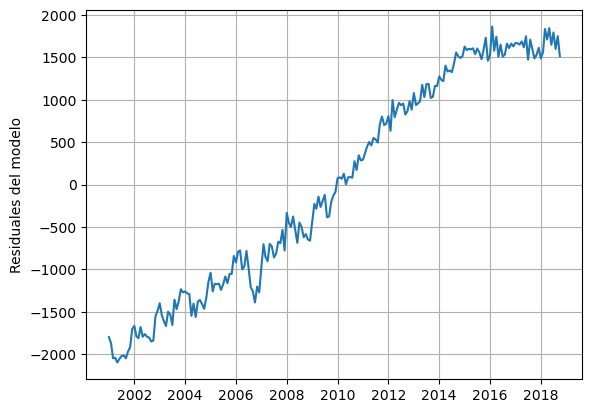

In [7]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

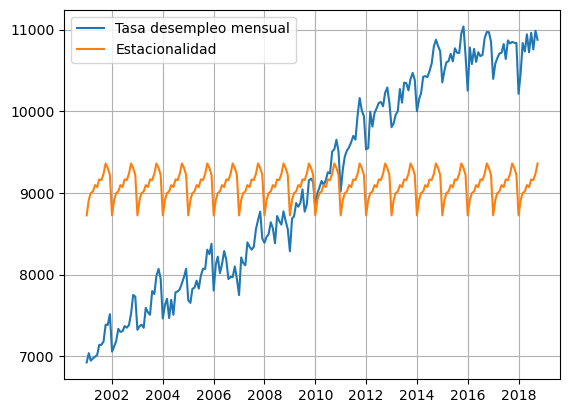

In [8]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(season.fittedvalues,label="Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [9]:
range_dates = pd.date_range(train_td.index[-1]+ relativedelta(months=1), periods=6,freq='MS')
X_for= sm.add_constant(test_dummy)

print(X_for)

            const  2  3  4  5  6  7  8  9  10  11  12
mes                                                  
2018-11-01    1.0  0  0  0  0  0  0  0  0   0   1   0
2018-12-01    1.0  0  0  0  0  0  0  0  0   0   0   1
2019-01-01    1.0  0  0  0  0  0  0  0  0   0   0   0
2019-02-01    1.0  1  0  0  0  0  0  0  0   0   0   0
2019-03-01    1.0  0  1  0  0  0  0  0  0   0   0   0
2019-04-01    1.0  0  0  1  0  0  0  0  0   0   0   0


In [10]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)

print(preds)

            Point_forecast     lower_95      upper_95
2018-11-01     9304.549471  6652.685489  11956.413452
2018-12-01     9220.622941  6568.758960  11872.486922
2019-01-01     8724.538722  6076.770286  11372.307158
2019-02-01     8914.544389  6266.775953  11562.312825
2019-03-01     8997.218333  6349.449897  11644.986769
2019-04-01     9017.681722  6369.913286  11665.450158


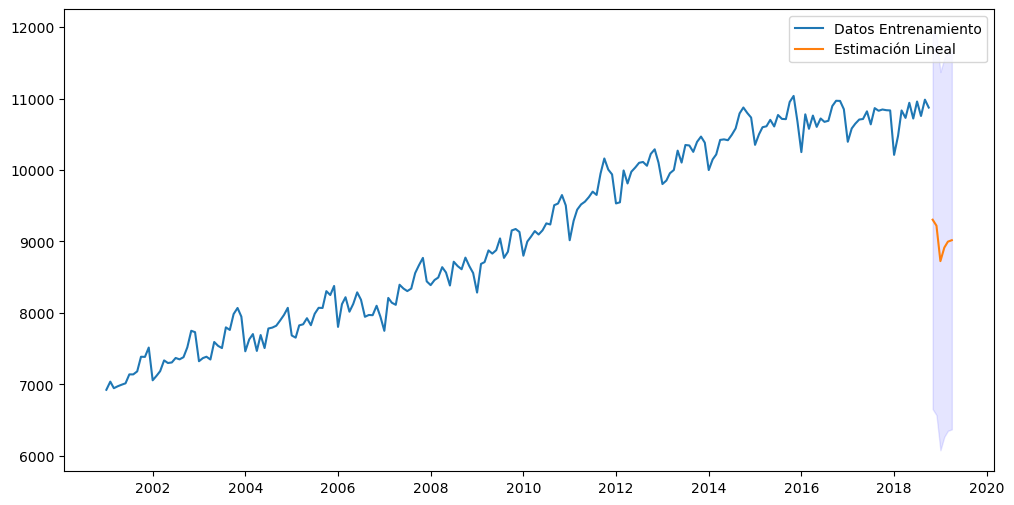

In [11]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Lineal")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [12]:
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_lineal = r2_score(y_test, y_prd)
rmse_lineal = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R2 : {r2_lineal}")
print(f"RMSE : {rmse_lineal}")

Resultados = Resultados.append({'Modelo': 'Tendencia Lineal + Estacionalidad', 'Configuración': 'x + estacionalidad', 'RMSE': rmse_lineal, 'Coef R2': r2_lineal}, ignore_index=True)


Coef R2 : -83.72112169140883
RMSE : 1619.6142268040398


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9004\1722862165.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Tendencia Lineal + Estacionalidad', 'Configuración': 'x + estacionalidad', 'RMSE': rmse_lineal, 'Coef R2': r2_lineal}, ignore_index=True)


In [13]:
# CUADRATICA

In [14]:
## Generacion de modelo usado split de la data completa y split de dummies
y = train_td["Ocupados"]
x = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x"] = x
train_td["x2"] = x**2
X = sm.add_constant(pd.concat([train_td[["x","x2"]],train_dummy],axis=1))
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     546.8
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          1.87e-148
Time:                        14:51:13   Log-Likelihood:                -1449.9
No. Observations:                 214   AIC:                             2928.
Df Residuals:                     200   BIC:                             2975.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6573.7362     66.544     98.787      0.0

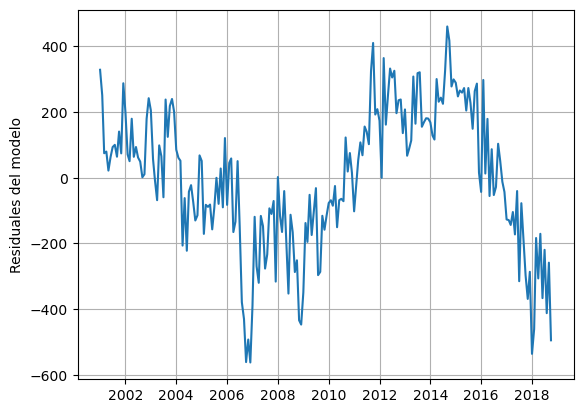

In [15]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

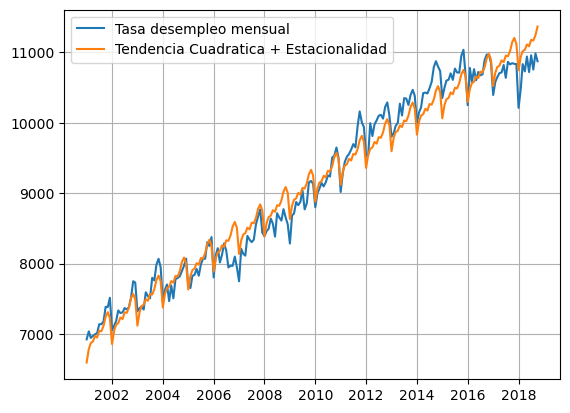

In [16]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica + Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [17]:
h=6
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] ) # Dataframe de los x

#Dado que en test dummy (el split de los dummies) se tienen las fechas a predecir, se reinicia le indice
test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_ 
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for


,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,215.0,46225.0,0,0,0,0,0,0,0,0,0,1,0
1,1.0,216.0,46656.0,0,0,0,0,0,0,0,0,0,0,1
2,1.0,217.0,47089.0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,218.0,47524.0,1,0,0,0,0,0,0,0,0,0,0
4,1.0,219.0,47961.0,0,1,0,0,0,0,0,0,0,0,0
5,1.0,220.0,48400.0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    11429.502100  10976.254054  11882.750146
2018-12-01    11343.831463  10890.289749  11797.373176
2019-01-01    10971.226282  10518.323206  11424.129357
2019-02-01    11159.390945  10706.177657  11612.604234
2019-03-01    11240.223887  10786.691989  11693.755784
2019-04-01    11258.846273  10804.987388  11712.705157


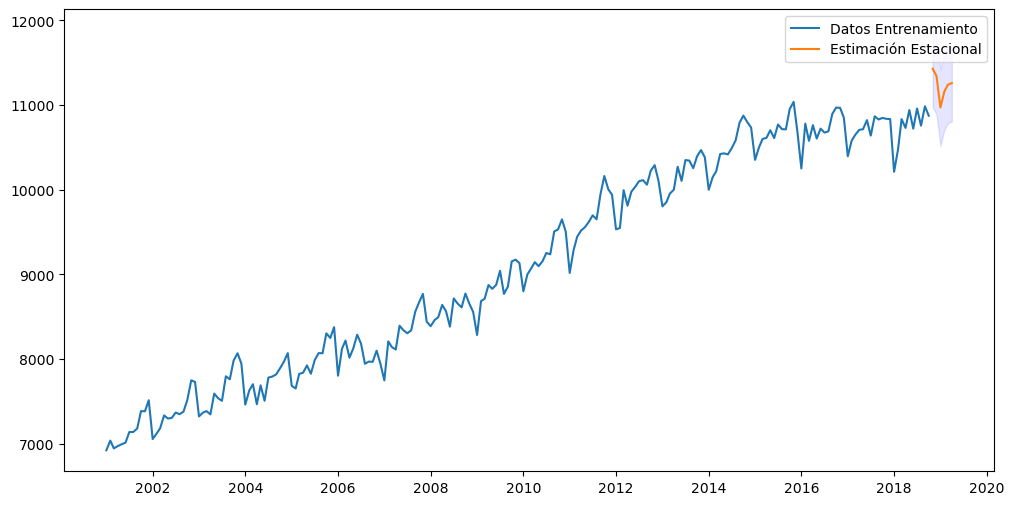

In [19]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [20]:
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_cuad = r2_score(y_test, y_prd)
rmse_cuad = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R2 : {r2_cuad}")
print(f"RMSE : {rmse_cuad}")

Resultados = Resultados.append({'Modelo': 'Tendencia Cuadratica + Estacionalidad', 'Configuración': 'x**2 + estacionalidad', 'RMSE': rmse_cuad, 'Coef R2': r2_cuad}, ignore_index=True)



Coef R2 : -10.261031517356766
RMSE : 590.4794957116405


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9004\291755915.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Tendencia Cuadratica + Estacionalidad', 'Configuración': 'x**2 + estacionalidad', 'RMSE': rmse_cuad, 'Coef R2': r2_cuad}, ignore_index=True)


### Tendencia Cubica + Estacionalidad

In [21]:
## Generacion de modelo usado split de la data completa y split de dummies
y = train_td["Ocupados"]
x = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x"] = x
train_td["x2"] = x**2
train_td["x3"] = x**3
X = sm.add_constant(pd.concat([train_td[["x","x2","x3"]],train_dummy],axis=1))
pol = sm.OLS(y,X)
pol_3 = pol.fit()
print(pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1079.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          3.41e-179
Time:                        14:51:13   Log-Likelihood:                -1370.3
No. Observations:                 214   AIC:                             2771.
Df Residuals:                     199   BIC:                             2821.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6975.3189     53.370    130.698      0.0

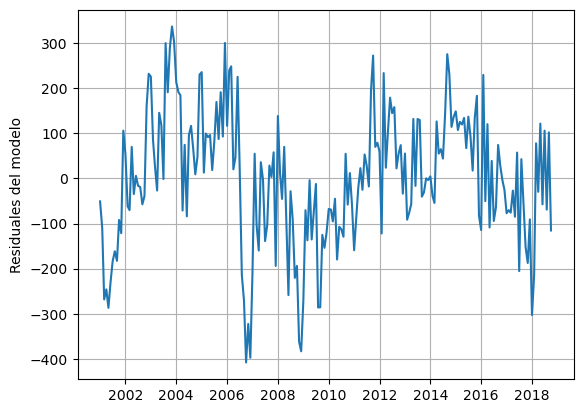

In [22]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_3.resid)
plt.grid()

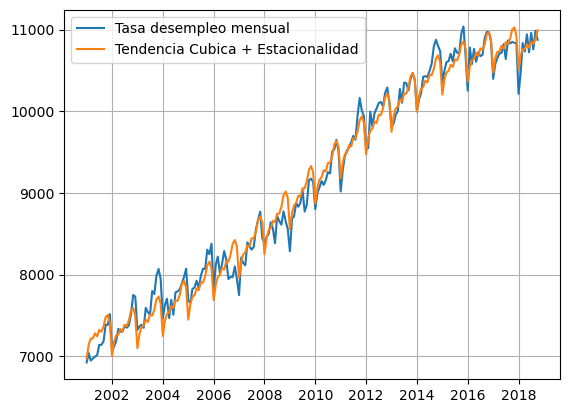

In [23]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_3.fittedvalues,label="Tendencia Cubica + Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [24]:
h=6
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3),axis=1),columns=["x","x2","x3"] ) # Dataframe de los x

#Dado que en test dummy (el split de los dummies) se tienen las fechas a predecir, se reinicia le indice
test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_ 
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for


,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
0,1.0,215.0,46225.0,9938375.0,0,0,0,0,0,0,0,0,0,1,0
1,1.0,216.0,46656.0,10077696.0,0,0,0,0,0,0,0,0,0,0,1
2,1.0,217.0,47089.0,10218313.0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,218.0,47524.0,10360232.0,1,0,0,0,0,0,0,0,0,0,0
4,1.0,219.0,47961.0,10503459.0,0,1,0,0,0,0,0,0,0,0,0
5,1.0,220.0,48400.0,10648000.0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
dt = pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    11008.558011  10690.367492  11326.748531
2018-12-01    10902.425454  10583.545307  11221.305601
2019-01-01    10486.540957  10166.983211  10806.098704
2019-02-01    10654.243701  10333.916200  10974.571202
2019-03-01    10714.046336  10392.905585  11035.187087
2019-04-01    10711.070029  10389.070892  11033.069165


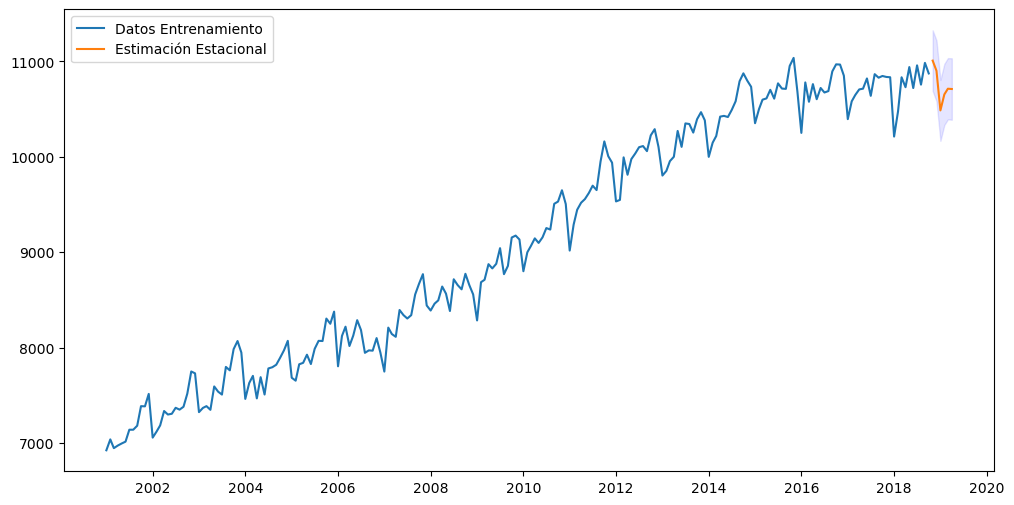

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [27]:
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_cub = r2_score(y_test, y_prd)
rmse_cub  = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R2 : {r2_cuad}")
print(f"RMSE : {rmse_cuad}")

Resultados = Resultados.append({'Modelo': 'Tendencia Cubica + Estacionalidad', 'Configuración': 'x**3 + estacionalidad', 'RMSE': rmse_cub, 'Coef R2': r2_cub}, ignore_index=True)


Coef R2 : -10.261031517356766
RMSE : 590.4794957116405


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9004\4049545225.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Tendencia Cubica + Estacionalidad', 'Configuración': 'x**3 + estacionalidad', 'RMSE': rmse_cub, 'Coef R2': r2_cub}, ignore_index=True)


### Tendencia Grado 5 + Estacionalidad

In [28]:
## Generacion de modelo usado split de la data completa y split de dummies
y = train_td["Ocupados"]
x = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x"] = x
train_td["x2"] = x**2
train_td["x3"] = x**3
train_td["x4"] = x**4
train_td["x5"] = x**5
X = sm.add_constant(pd.concat([train_td[["x","x2","x3","x4","x5"]],train_dummy],axis=1))
pol = sm.OLS(y,X)
pol_5 = pol.fit()
print(pol_5.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1447.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):          1.19e-194
Time:                        14:51:14   Log-Likelihood:                -1324.0
No. Observations:                 214   AIC:                             2682.
Df Residuals:                     197   BIC:                             2739.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6588.6414     58.135    113.334      0.0

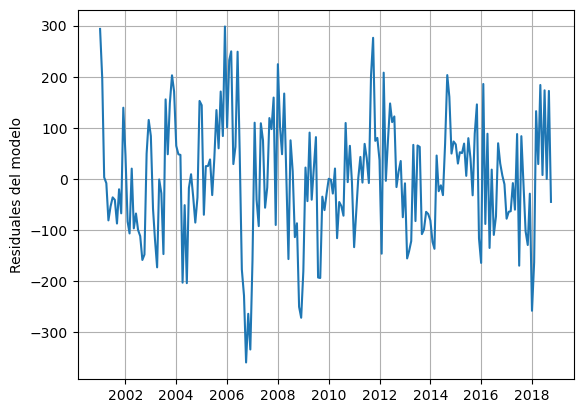

In [29]:
# Grafico de residuales tendencia grado 5
plt.ylabel("Residuales del modelo")
plt.plot(pol_5.resid)
plt.grid()


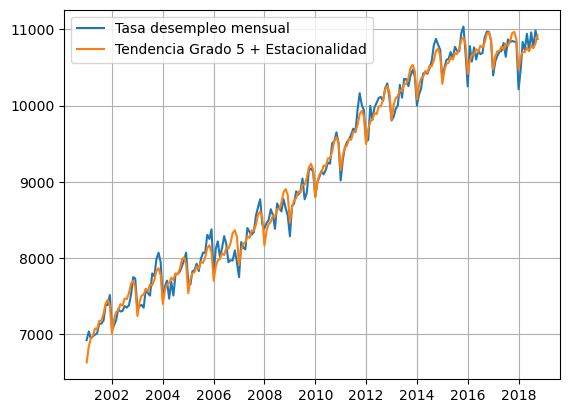

In [30]:
# Grafico de Ajuste
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_5.fittedvalues,label="Tendencia Grado 5 + Estacionalidad")
plt.legend()
plt.grid()
plt.show()


In [31]:
#Generacion de X's para predicicon
h=6
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3, x_for**4,x_for**5),axis=1),columns=["x","x2","x3","x4","x5"] ) # Dataframe de los x

#Dado que en test dummy (el split de los dummies) se tienen las fechas a predecir, se reinicia le indice
test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_ 
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for



,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
0,1.0,215.0,46225.0,9938375.0,2.136751e+09,4.594014e+11,0,0,0,0,0,0,0,0,0,1,0
1,1.0,216.0,46656.0,10077696.0,2.176782e+09,4.701850e+11,0,0,0,0,0,0,0,0,0,0,1
2,1.0,217.0,47089.0,10218313.0,2.217374e+09,4.811701e+11,0,0,0,0,0,0,0,0,0,0,0
3,1.0,218.0,47524.0,10360232.0,2.258531e+09,4.923597e+11,1,0,0,0,0,0,0,0,0,0,0
4,1.0,219.0,47961.0,10503459.0,2.300258e+09,5.037564e+11,0,1,0,0,0,0,0,0,0,0,0
5,1.0,220.0,48400.0,10648000.0,2.342560e+09,5.153632e+11,0,0,1,0,0,0,0,0,0,0,0


In [32]:
# Prediccion con modelo tendencia grado 5 + estacionalidad
dt = pol_5.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)


            Point_forecast      lower_95      upper_95
2018-11-01    10934.192586  10664.266751  11204.118420
2018-12-01    10829.061639  10555.708546  11102.414732
2019-01-01    10435.194388  10157.775673  10712.613103
2019-02-01    10603.220836  10321.369119  10885.072553
2019-03-01    10664.261722  10377.400683  10951.122761
2019-04-01    10663.461760  10370.970139  10955.953381


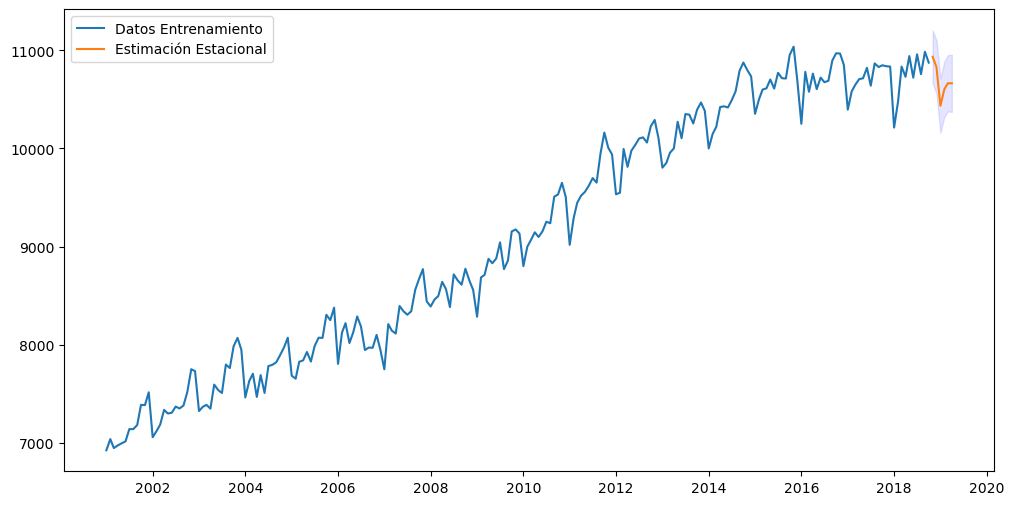

In [33]:
#Grafico de predicciones con modelo tendencia grado 5 + estacionalidad
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()


In [34]:
#Calculo de errores con modelo tendencia grado 5 + estacionalidad
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_g5 = r2_score(y_test, y_prd)
rmse_g5  = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R2 : {r2_cuad}")
print(f"RMSE : {rmse_cuad}")

Resultados = Resultados.append({'Modelo': 'Tendencia Pol. grado 5 + Estacionalidad', 'Configuración': 'x**5 + estacionalidad', 'RMSE': rmse_g5, 'Coef R2': r2_g5}, ignore_index=True)



Coef R2 : -10.261031517356766
RMSE : 590.4794957116405


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9004\856685982.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Tendencia Pol. grado 5 + Estacionalidad', 'Configuración': 'x**5 + estacionalidad', 'RMSE': rmse_g5, 'Coef R2': r2_g5}, ignore_index=True)


### Tendencia Grado 7 + Estacionalidad

In [35]:

## Generacion de modelo usado split de la data completa y split de dummies
y = train_td["Ocupados"]
x = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x"] = x
train_td["x2"] = x**2
train_td["x3"] = x**3
train_td["x4"] = x**4
train_td["x5"] = x**5
train_td["x6"] = x**6
train_td["x7"] = x**7
X = sm.add_constant(pd.concat([train_td[["x","x2","x3","x4","x5","x6","x7"]],train_dummy],axis=1))
pol = sm.OLS(y,X)
pol_7 = pol.fit()
print(pol_7.summary())


                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                      -0.849
Model:                            OLS   Adj. R-squared:                 -0.893
Method:                 Least Squares   F-statistic:                    -19.10
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               1.00
Time:                        14:51:15   Log-Likelihood:                -1900.7
No. Observations:                 214   AIC:                             3813.
Df Residuals:                     208   BIC:                             3834.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0873      0.005     17.300      0.0

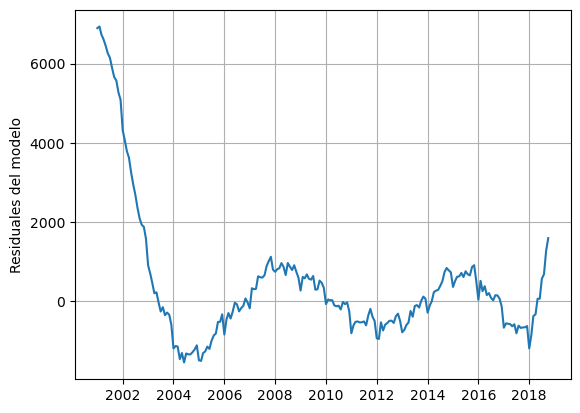

In [36]:
# Grafico de residuales tendencia grado 5
plt.ylabel("Residuales del modelo")
plt.plot(pol_7.resid)
plt.grid()


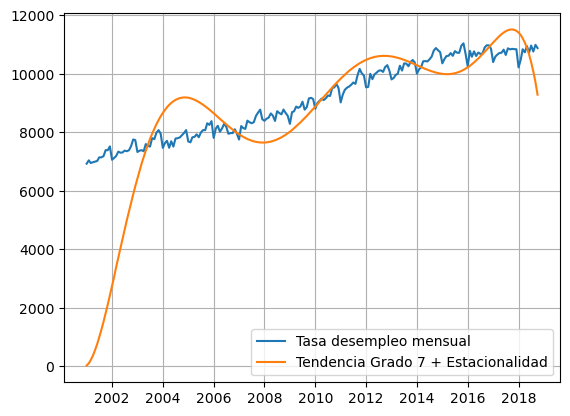

In [37]:
# Grafico de Ajuste
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_7.fittedvalues,label="Tendencia Grado 7 + Estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [38]:
#Generacion de X's para predicicon
h=6
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3, x_for**4,x_for**5, x_for**6,x_for**7),axis=1),columns=["x","x2","x3","x4","x5","x6","x7"] ) # Dataframe de los x

#Dado que en test dummy (el split de los dummies) se tienen las fechas a predecir, se reinicia le indice
test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_ 
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for



,const,x,x2,x3,x4,x5,x6,x7,2,3,4,5,6,7,8,9,10,11,12
0,1.0,215.0,46225.0,9938375.0,2.136751e+09,4.594014e+11,9.877130e+13,2.123583e+16,0,0,0,0,0,0,0,0,0,1,0
1,1.0,216.0,46656.0,10077696.0,2.176782e+09,4.701850e+11,1.015600e+14,2.193695e+16,0,0,0,0,0,0,0,0,0,0,1
2,1.0,217.0,47089.0,10218313.0,2.217374e+09,4.811701e+11,1.044139e+14,2.265782e+16,0,0,0,0,0,0,0,0,0,0,0
3,1.0,218.0,47524.0,10360232.0,2.258531e+09,4.923597e+11,1.073344e+14,2.339890e+16,1,0,0,0,0,0,0,0,0,0,0
4,1.0,219.0,47961.0,10503459.0,2.300258e+09,5.037564e+11,1.103227e+14,2.416066e+16,0,1,0,0,0,0,0,0,0,0,0
5,1.0,220.0,48400.0,10648000.0,2.342560e+09,5.153632e+11,1.133799e+14,2.494358e+16,0,0,1,0,0,0,0,0,0,0,0


In [39]:
# Prediccion con modelo tendencia grado 7 + estacionalidad
dt = pol_7.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)


            Point_forecast     lower_95      upper_95
2018-11-01     8792.311171  4787.523050  12797.099292
2018-12-01     8235.083984  4080.519001  12389.648967
2019-01-01     7604.067919  3264.546867  11943.588971
2019-02-01     6893.376298  2329.442525  11457.310071
2019-03-01     6096.765074  1264.944393  10928.585756
2019-04-01     5207.703068    60.838746  10354.567390


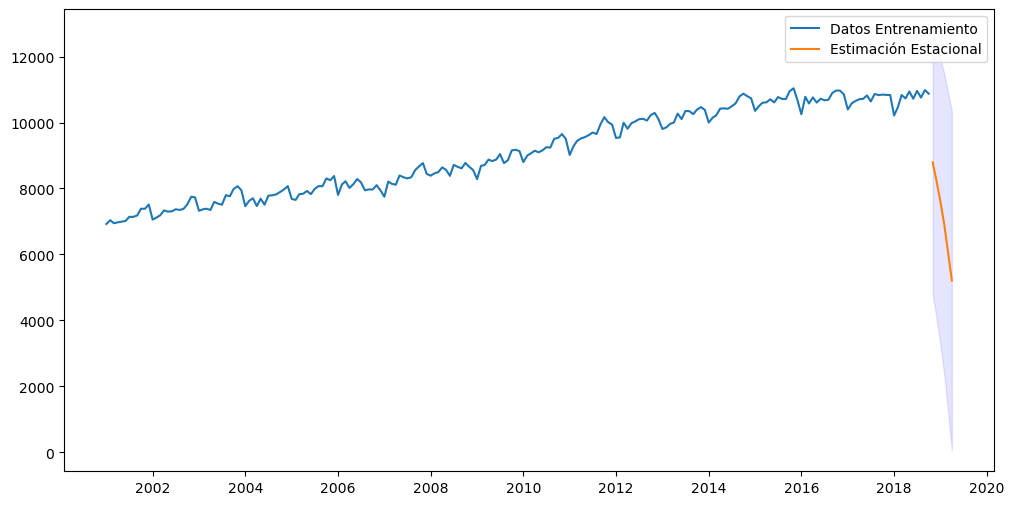

In [40]:
#Grafico de predicciones con modelo tendencia grado 7 + estacionalidad
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()


In [41]:
#Calculo de errores con modelo tendencia grado 5 + estacionalidad
# Tomar y_test del conjunto de prueba
y_test = test_td["Ocupados"]
# Convertir índices de y_test a números para que coincidan con y_prd
y_test.index = range(len(y_test))

r2_g7 = r2_score(y_test, y_prd)
rmse_g7  = np.sqrt(mean_squared_error(y_test, y_prd))
print(f"Coef R2 : {r2_cuad}")
print(f"RMSE : {rmse_cuad}")

Resultados = Resultados.append({'Modelo': 'Tendencia Pol. grado 7 + Estacionalidad', 'Configuración': 'x**7 + estacionalidad', 'RMSE': rmse_g7, 'Coef R2': r2_g7}, ignore_index=True)



Coef R2 : -10.261031517356766
RMSE : 590.4794957116405


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9004\3897698975.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Resultados = Resultados.append({'Modelo': 'Tendencia Pol. grado 7 + Estacionalidad', 'Configuración': 'x**7 + estacionalidad', 'RMSE': rmse_g7, 'Coef R2': r2_g7}, ignore_index=True)


In [42]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,Tendencia Lineal + Estacionalidad,x + estacionalidad,1619.614227,-83.721122
1,Tendencia Cuadratica + Estacionalidad,x**2 + estacionalidad,590.479496,-10.261032
2,Tendencia Cubica + Estacionalidad,x**3 + estacionalidad,130.743940,0.447908
3,Tendencia Pol. grado 5 + Estacionalidad,x**5 + estacionalidad,91.055527,0.732218
4,Tendencia Pol. grado 7 + Estacionalidad,x**7 + estacionalidad,3712.073296,-444.042634


In [49]:
Resultados.to_csv('resultados_t2_modelo.csv', index=False)

In [43]:
# union de tablas para comparar resultados.

In [44]:
Resultados_t1 = pd.read_csv('resultados_t1_modelo.csv')
Resultados_t2 = Resultados

Resultados_t1['Origen'] = 'Taller 1'
Resultados_t2['Origen'] = 'Taller 2'


In [45]:
Resultados_combinados = pd.concat([Resultados_t1, Resultados_t2], ignore_index=True)

In [46]:
Resultados_combinados = Resultados_combinados.sort_values(by='RMSE', ascending=True)
Resultados_t2_ = Resultados_t2.sort_values(by='RMSE', ascending=True)
top_10_resultados_t2 = Resultados_t2_.head(10)
top_10_resultados = Resultados_combinados.head(10)
top_10_resultados_t2

,Modelo,Configuración,RMSE,Coef R2,Origen
3,Tendencia Pol. grado 5 + Estacionalidad,x**5 + estacionalidad,91.055527,0.732218,Taller 2
2,Tendencia Cubica + Estacionalidad,x**3 + estacionalidad,130.743940,0.447908,Taller 2
1,Tendencia Cuadratica + Estacionalidad,x**2 + estacionalidad,590.479496,-10.261032,Taller 2
0,Tendencia Lineal + Estacionalidad,x + estacionalidad,1619.614227,-83.721122,Taller 2
4,Tendencia Pol. grado 7 + Estacionalidad,x**7 + estacionalidad,3712.073296,-444.042634,Taller 2


In [47]:
top_10_resultados

,Modelo,Configuración,RMSE,Coef R2,Origen
33,Suavizacion Exp Lineal de Winters (Holt-Winters),add/None/add,74.994180,0.818355,Taller 1
45,Tendencia Pol. grado 5 + Estacionalidad,x**5 + estacionalidad,91.055527,0.732218,Taller 2
36,Suavizacion Exp Lineal de Winters (Holt-Winters),add/None/mul,93.497528,0.717662,Taller 1
41,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/None/mul,97.452411,0.693272,Taller 1
38,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/None/add,115.889161,0.566235,Taller 1
44,Tendencia Cubica + Estacionalidad,x**3 + estacionalidad,130.743940,0.447908,Taller 2
27,Suavizacion Exp Lineal de Winters (Holt-Winters),add/mul/mul,154.837076,0.225684,Taller 1
25,Suavizacion Exp Lineal de Winters (Holt-Winters),add/add/mul,156.414737,0.209824,Taller 1
28,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/mul/mul,160.577047,0.167210,Taller 1
30,Suavizacion Exp Lineal de Winters (Holt-Winters),mul/add/mul,162.249785,0.149769,Taller 1


In [ ]:
Resultados.to_csv('resultados_t1_modelo.csv', index=False)

In [48]:
### PRUEBAS DE SUSPUESTOS SOBRE EL MODELO QUE MEJOR AJUSTO CON EL RMSE y/o Coef R2 
#en EL TALLER 2 para comparar contra los supuestos del TALLER 1

## GENERACION DE MODELOS COMPLETOS

In [116]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.tail()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


In [117]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)
month_dummies.tail()

,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2018-12-01,0,0,0,0,0,0,0,0,0,0,1
2019-01-01,0,0,0,0,0,0,0,0,0,0,0
2019-02-01,1,0,0,0,0,0,0,0,0,0,0
2019-03-01,0,1,0,0,0,0,0,0,0,0,0
2019-04-01,0,0,1,0,0,0,0,0,0,0,0


In [118]:
## Generacion de modelo usado split de la data completa y split de dummies
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
data["x"] = x
data["x2"] = x**2
data["x3"] = x**3
data["x4"] = x**4
data["x5"] = x**5
X = sm.add_constant(pd.concat([data[["x","x2","x3","x4","x5"]],month_dummies],axis=1))
pol = sm.OLS(y,X)
pol_5 = pol.fit()
print(pol_5.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1529.
Date:                Sat, 24 Feb 2024   Prob (F-statistic):          6.92e-202
Time:                        19:29:23   Log-Likelihood:                -1359.6
No. Observations:                 220   AIC:                             2753.
Df Residuals:                     203   BIC:                             2811.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6586.1092     56.850    115.852      0.0

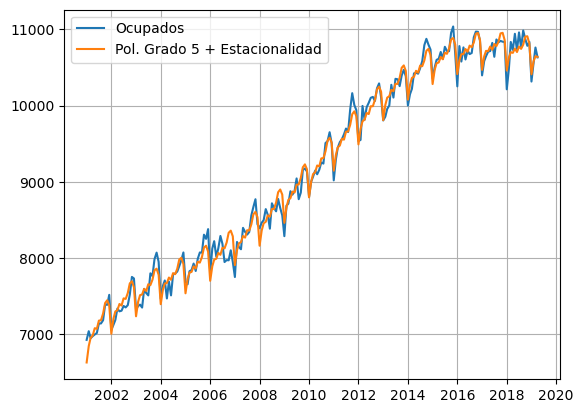

In [119]:
plt.plot(y,label="Ocupados")
plt.plot(pol_5.fittedvalues,label="Pol. Grado 5 + Estacionalidad")
plt.legend()
plt.grid()
plt.show()

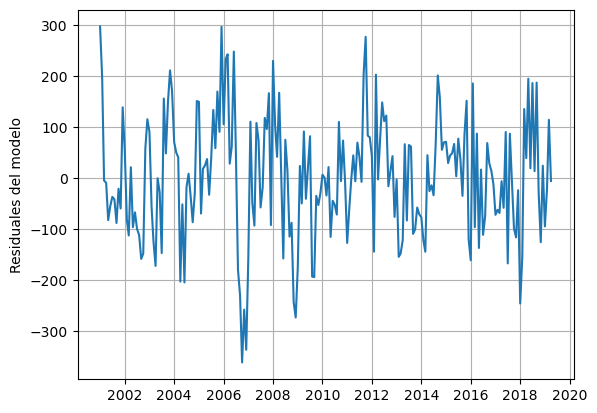

In [120]:
residuos_pg5 = pol_5.resid
plt.ylabel("Residuales del modelo")
plt.plot(residuos_pg5)
plt.grid()

## PRONÓSTICO 

In [121]:
#Generacion de X's para predicicon
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h) # generando x's para predecir
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2,x_for**3, x_for**4,x_for**5),axis=1),
                                 columns=["x","x2","x3","x4","x5"] ) # Dataframe de los x
test_dummy_ = test_dummy
test_dummy_ = test_dummy_.reset_index(drop=True)
test_dummy_ 
X_for= sm.add_constant(pd.concat([x_for_all,test_dummy_],axis=1))
X_for

,const,x,x2,x3,x4,x5,2,3,4,5,6,7,8,9,10,11,12
0,1.0,221.0,48841.0,10793861.0,2.385443e+09,5.271830e+11,0,0,0,0,0,0,0,0,0,1,0
1,1.0,222.0,49284.0,10941048.0,2.428913e+09,5.392186e+11,0,0,0,0,0,0,0,0,0,0,1
2,1.0,223.0,49729.0,11089567.0,2.472973e+09,5.514731e+11,0,0,0,0,0,0,0,0,0,0,0
3,1.0,224.0,50176.0,11239424.0,2.517631e+09,5.639493e+11,1,0,0,0,0,0,0,0,0,0,0
4,1.0,225.0,50625.0,11390625.0,2.562891e+09,5.766504e+11,0,1,0,0,0,0,0,0,0,0,0
5,1.0,226.0,51076.0,11543176.0,2.608758e+09,5.895793e+11,0,0,1,0,0,0,0,0,0,0,0


In [122]:
# Prediccion con modelo tendencia grado 5 + estacionalidad
dt = pol_5.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    10881.154739  10615.234024  11147.075454
2018-12-01    10783.771733  10514.778748  11052.764718
2019-01-01    10382.145091  10109.474390  10654.815792
2019-02-01    10553.423062  10276.791653  10830.054471
2019-03-01    10621.340592  10340.243556  10902.437627
2019-04-01    10613.355427  10327.248459  10899.462396


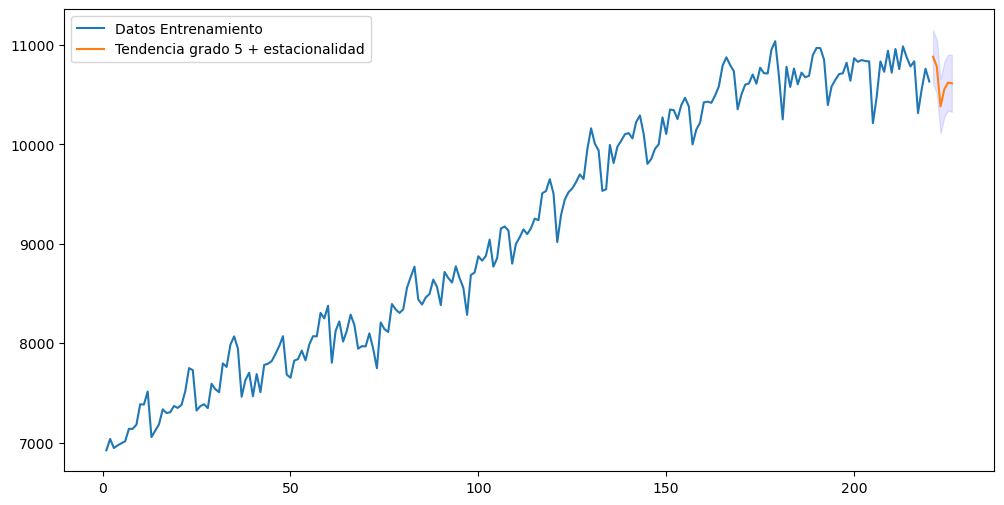

In [123]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia grado 5 + estacionalidad")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## PRUEBAS DE SUPUESTOS 
### **Autocorrelación**

In [124]:
signo = residuos_pg5>0
runstest_1samp(signo, correction=False) #estadistico y probabilidad que hay por encima del estadistico

(-3.9157035347444533, 9.014096112799542e-05)

Los resultados **si permiten rechazar h0** (valor p de 0) la **no autocorrelacion** y
por tanto se puede concluir que **existe autocorrelacion en la serie**. Es decir, con
esta prueba y en este aspecto, la serie parece **NO comportarse como un ruido blanco**. (media cero, varianza cero y autocorrelacion no cambia en el tiempo)

[Si es menor a 0.05 rechazo H0 y existe autocorrelacion]

In [125]:
# prueba de Box-Pierce y la modificación de Ljung-Box 
sm.stats.acorr_ljungbox(residuos_pg5, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,35.437898,2.633133e-09,34.959008,3.367201e-09


Los resultados **si permiten rechazar h0** (valor p de 0) la **no autocorrelacion** y
por tanto se puede concluir que **existe autocorrelacion en la serie**. Es decir, con
esta prueba y en este aspecto, la serie parece **NO comportarse como un ruido blanco**. (media cero, varianza cero y autocorrelacion no cambia en el tiempo)

[Si es menor a 0.05 rechazo H0 y existe autocorrelacion]

In [131]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuos_pg5, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,35.437898,2.633133e-09,34.959008,3.367201e-09,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,53.988243,1.890611e-12,53.175112,2.839038e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,64.253583,7.244498e-14,63.209251,1.211520e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,64.858918,2.755461e-13,63.798226,4.608669e-13,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,65.170108,1.033277e-12,64.099603,1.722712e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,65.822649,2.929749e-12,64.728629,4.900960e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,67.912128,3.899159e-12,66.733400,6.737367e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,71.524119,2.442100e-12,70.182688,4.519582e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,72.378038,5.194277e-12,70.994295,9.716508e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,75.124856,4.498855e-12,73.592637,8.933773e-12,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


### **Homoscedasticidad y Heteroscedasticidad**


$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [1]:
sm.stats.acorr_ljungbox((residuos_pg5-residuos_pg5.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )
### SE RESTA LA MEDIA Y SE ELEVA AL CUADRADO 

NameError: name 'sm' is not defined

 Si p-value es Menor a 0.05 (Significancia) entonces Rechazo y concluyo que los errores NO son homocedasticos - por tanto son Heteroscedasticos - hay comportamiento ARCH o GARCH.

### **Normalidad**

$H{0}:$ Los datos siguen una distribucion normal

$H{1}:$ Los datos No siguen una distribucion normal

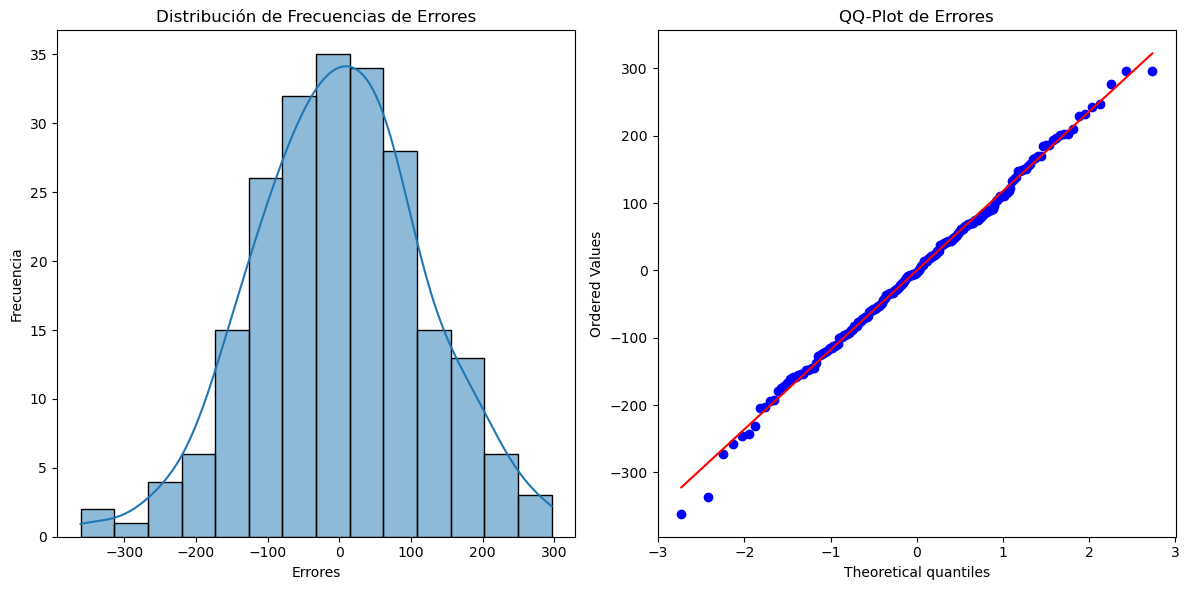

In [128]:
# Distribución de Frecuencias
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuos_pg5, kde=True)
plt.xlabel('Errores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencias de Errores')

# QQ-Plot
plt.subplot(1, 2, 2)
stats.probplot(residuos_pg5, plot=plt) #sm.qqplot(residuos_pg5,line="s")
plt.title('QQ-Plot de Errores')

plt.tight_layout()
plt.show()

In [129]:
stats.shapiro(residuos_pg5)

ShapiroResult(statistic=0.9967400431632996, pvalue=0.9297927618026733)

In [130]:
stats.jarque_bera(residuos_pg5)

SignificanceResult(statistic=0.2691747297641466, pvalue=0.8740765119493374)

Para ambas pruebas el p-value > 0.05 , por tanto no hay suficiente informacion estadistica para rechazar la hipótesis de que los datos provienen de una distribución normal, es decir, **los datos provienen de una distribucion normal**.

## CONCLUSION

Con estas pruebas de supuestos (Autocorrelación : Hay Autocorrelacion, Heteroscedasticidad : Hay Heteroscedasticidad y Normalidad : Distribuyen normal), y que es el modelo con menor Error RMSE : 91.055 y mayor Coef R2 (cercano a 1) : 0.732 

El mejor modelo es tendencia polinomica de grado 5 + estacionalidad.